### Mission Statement
* In this simulation, a popular YouTuber has asked to analyze the comment section from one of his recent videos
    * This is perhaps analagous to analyzing reviews on a product, feedback on a survey, complaints to customer service, etc.
* YouTuber's asks:
    * What are the broad things people talking about in the comments on the video?
    * There are 2 ads in the video. Are people talking about the ads?
    * Is there anything else useful, or any other insights than can be gleaned?

General Directions from the YouTuber:
* The number of likes is a big part of engagement. A comment with 100 likes is much more relevant than one with 1 like.
* There are going to be many things discussed in the comments. We only want the high level categories at this moment. We expect there to be less than 10 categories.

### General Process
* Pull the data from YouTube
    * Get all comments and the number of likes for each comment
* Clean the data
    * Remove any duplicates
        * The pinned comment is the only one true duplicate
        * If the same comment is posted by different users, combine it into one comment with the total number of likes
    * Translate all comments to English
    * Remove comments with zero likes. We can assume they are just noise
* Get text embedding of each unique comment
* Perform dimensionality reduction
    * Clustering algorithms generally perform better in relatively low dimensional space
* Cluster the comments
    * Assume that each comment has 1 topic, and that 1 topic fits nicely into a single high level category (plus a catch-all for noise)
    * Use a weighted clustering algorithm with the number of likes acting as the sample weight
    * Make it so comments in a cluster have an explainable topic
    * Limit the number of final clusters to be less than 10
    * If there are comments related to the advertisements, make sure at least 1 cluster reflects this
* Report back with the topic(s) of each cluster

In [1]:
import os
import time
from azure.core.credentials import AzureKeyCredential
from azure.ai.translation.text import TextTranslationClient
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

# APIs
GOOGLE_API_KEY = os.environ.get("GOOGLE_KEY")
AZURE_KEY = os.environ.get("AZURE_KEY")
AZURE_ENDPOINT = "https://api.cognitive.microsofttranslator.com"
AZURE_REGION = "southcentralus"

# Video ID
VIDEO_ID = "KOEfDvr4DcQ"

# Save the intermediate steps so we don't have to do reprocessing
CACHE_DIR = "./data/youtube_comments"
os.makedirs(CACHE_DIR, exist_ok=True)
RAW_COMMENTS_PATH        = os.path.join(CACHE_DIR, VIDEO_ID + "_raw.csv")
CLEANED_COMMENTS_PATH    = os.path.join(CACHE_DIR, VIDEO_ID + "_cleaned.csv")
TRANSLATED_COMMENTS_PATH = os.path.join(CACHE_DIR, VIDEO_ID + "_translated.csv")
FINAL_COMMENTS_PATH      = os.path.join(CACHE_DIR, VIDEO_ID + "_final.csv")
DOCUMENT_EMBEDDINGS_PATH = os.path.join(CACHE_DIR, VIDEO_ID + "_document_embeddings.npy")
QUERY_EMBEDDINGS_PATH    = os.path.join(CACHE_DIR, VIDEO_ID + "_query_embeddings.npy")
FIRST_CLUSTERING_PATH    = os.path.join(CACHE_DIR, VIDEO_ID + "_first_clustering.csv")

# Model ID and Parameters
EMBEDDING_MODEL_ID = "Alibaba-NLP/gte-Qwen2-7B-instruct"
EMBEDDING_MAX_LENGTH = 8192

### Data Collection

Inside the simulation, the video selected has been assigned to us. Our stakeholder, MrBeast, has asked us to do this analysis on his most watched video of 2024, "Face Your Biggest Fear To Win $800,000". At time of data collection, the video has ~300M views and ~215k comments. The comments have a collective ~1.1M likes.

Outside the simulation, I choose this video because I wanted a dataset that is representative of real-world data in order to showcase real-world data wrangling and data analysis skills. It did not take long to settle on a popular YouTube video. The comments are short, which can it difficult to get good text embeddings. The comments come in many languages, and (at least in English) often have misspellings, poor grammar, and unique words like "Mr Beast" which wouldn't necessarily be prelevlant in the embedding model's training data. The comments range from well written, full sentences to chants or even to single words or single emojis. It is not a pretty dataset. In my opinion, it is representative of an actual dataset that would be used to extract business insights. Size-wise the dataset is representative - it may be a tad small relatively speaking, but it also takes ~24 hours to run the notebook from scratch on my personal computer (so it's about as large as I can reasonably handle). Quality-wise it representative as well - the only caveat is that most comments are short and communicates only a single, simple idea. Short pieces of text with single, simple ideas is still representative of many datasets but that can vary wildly.

In [2]:
# Collect the Data

# If the comments have already been pulled and saved, just load them
if os.path.exists(RAW_COMMENTS_PATH):
    raw_comments = pd.read_csv(RAW_COMMENTS_PATH)
    raw_comments["Text"] = raw_comments["Text"].fillna("") # Fill any empty comments with empty string

# If they haven't been saved, pull them then save them
else:
    # Collect comments in batches of 1000
    BATCH_SIZE = 1000

    # Initialize the responses list and start token
    responses = []
    token = None

    # Get a batch of comment threads
    #   Each comment thread has a top comment and all replies directly to that comment
    #   Each batch is a "page", and comes with a "nextPageToken"
    # The response is a linked list. If response["nextPageToken"] is not None, there are more comments
    #   Get responses until there are no more remaining (response["nextPageToken"] is None)
    youtube = build('youtube', 'v3', developerKey=GOOGLE_API_KEY)
    while True:
        # Get the response and append it to the list of responses
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=VIDEO_ID,
            maxResults=BATCH_SIZE,
            pageToken=token,
            textFormat="plainText",
        ).execute()
        responses.append(response)

        # Check if there are more comments remaining
        if "nextPageToken" in response:
            token = response["nextPageToken"]
        else:
            break

    # Get the text, number of likes, and ID of each comment. Save it to a csv
    raw_comments = [
        (
            thread["snippet"]["topLevelComment"]["snippet"]["textDisplay"],
            thread["snippet"]["topLevelComment"]["snippet"]["likeCount"],
            thread["id"]
        )
        for response in responses for thread in response["items"]
    ]
    raw_comments = pd.DataFrame(raw_comments, columns=["Text", "Likes", "Id"])
    raw_comments.to_csv(RAW_COMMENTS_PATH, index=False)

### Data Cleaning
* Of the ~215k comments, there are only ~144k unique comment texts (many repeated comments)
    * This seems to be mostly a combination of bots reposting comments, and trivial messages (many times just an emoji)
    * However, it is also the same (non-trivial) comment being naturally posted several times
* We can combine two rows if their text is the same, and add their likes together
* Of the ~144k unique comments, only ~33k have at least 1 like
    * We can assume the unliked comments are noise, so we can remove them
        * This should be confirmed with our stakeholders, but it would regardless be a good filtering mechanism for preliminary insights
* Since we will eventually be doing topic modeling with TF-IDF, we want all comments in one language. I selected English because most comments are in English, the vast majority of likes are on Ensligh comments, and I only speak English.
    * To translate, we can run all the comments through Microsoft Cognitive Services Text Translation
        * Translation is generally good, but isn't perfect
            * Short comments in English sometimes get labeled as some other language then get a "wonky" translation back to English. Ex:
                * Original: &emsp;*Maaacck!!...MUAAAACCK* !! - Arnold Schwarzenegger (Tahitian detected)
                * Translated: *Maaacck!! ... MUAAAACCK* - Arnold Arnold Arnold
    * ~70% of unique comment texts are detected as English
        * ~97% of likes are on comments detected as English
* After translating, there are new duplicates. We can combine them like we did earlier in this step
    * "Hola" and "Hello" wouldn't originally be combined, but after translating both now say "Hello" and can be combined
    * This reduces the number of comments by ~1.8% (~33.2k comments reduces to ~32.6k)

In [3]:
# Remove duplicated and comments with 0 likes
if os.path.exists(CLEANED_COMMENTS_PATH):
    cleaned_comments = pd.read_csv(CLEANED_COMMENTS_PATH)
    cleaned_comments["Text"] = cleaned_comments["Text"].fillna("")

else:
    # MrBeast's pinned comment is the only true duplicated comment
    cleaned_comments = raw_comments.drop_duplicates()

    # Combine two or more comments if their text is identical. Sum the likes from all combined comments
    #   Keep the ID of the comment with more likes
    cleaned_comments = cleaned_comments.sort_values(by="Likes", ascending=False)
    cleaned_comments = cleaned_comments.groupby("Text", as_index=False).agg({
        "Likes": "sum",
        "Id": "first"
    })

    # Most comments still have 0 likes. Anything with zero noise is considered noise
    cleaned_comments = cleaned_comments[cleaned_comments["Likes"] > 0]

    # Save the cleaned comments to disk
    cleaned_comments.to_csv(CLEANED_COMMENTS_PATH, index=False)

In [4]:
# Translate all comments to English
#   We need all comments in one language so we can properly perform TF-IDF later
#       Most comments are English, most likes are on English comments, and I can only speak English
#   We want to translate before embedding since language is likely represented in the embedding
#       Unfortunately, the translation isn't perfect, but it will be good enough

# The tier of the translation service that I am using has a rate limit of 33k characters per minute.
#   Notably, the documentation only mentions a 2M limit per hour, but if I send more than 33k characters per minute (2M
#   per hour average) I get an "exceeded request limits" error.
# To make the code as simple as possible since it only needs to run once, I found that batching the requests into 200
#   comments never exceeds 33k characters. I can then wait a minute between each batch to avoid the rate limit.
# If this code was going to be run repeatedly, I'd use a variable batch size and pack each batch based on the character
#   count of each comment in the batch.
def language_and_enlish_translation(texts, batch_size = 200):
    """ Given a list of texts returns their source language and the translation of each item to English """
    client = TextTranslationClient(credential=AzureKeyCredential(AZURE_KEY), region=AZURE_REGION, endpoint=AZURE_ENDPOINT)
    response = []

    for i in range(0, len(texts), batch_size):
        texts_batch = texts[i:i + batch_size]
        response += client.translate(body=texts_batch, to_language=["en"])
        time.sleep(60)

    return [
        (item["detectedLanguage"]["language"], item["translations"][0]["text"])
        for item in response
    ]

if os.path.exists(TRANSLATED_COMMENTS_PATH):
    translated_comments = pd.read_csv(TRANSLATED_COMMENTS_PATH)
    translated_comments[["Text", "English Text"]] = translated_comments[["Text", "English Text"]].fillna("")

else:
    translated_comments = cleaned_comments.copy()
    translated_comments.loc[:, ["Language", "English Text"]] = language_and_enlish_translation(translated_comments["Text"].tolist())
    translated_comments.to_csv(TRANSLATED_COMMENTS_PATH, index=False)

In [5]:
# Combine again after translating
# Now that everything is English, there may be more repeated comments
#   If the same comment was in two different languages, by translating all to English they would now be redundant
#   Previously "Hola" and "Hello" would not be combined. After translating both would be "Hello" and would be combined

if os.path.exists(FINAL_COMMENTS_PATH):
    final_comments = pd.read_csv(FINAL_COMMENTS_PATH)
    final_comments[["Text", "English Text"]] = final_comments[["Text", "English Text"]].fillna("")

else:
    # Combine if the English Text is the same and sum the likes
    final_comments = translated_comments.copy()
    final_comments = final_comments.sort_values(by="Likes", ascending=False)
    final_comments = final_comments.groupby("English Text", as_index=False).agg({
        "Likes": "sum",
        "Text": "first",
        "Language": "first",
        "Id": "first"
    })

    # Reset the index after cleaning is complete
    final_comments = final_comments.reset_index(drop=True)
    
    # Save the final comments to disk
    final_comments.to_csv(FINAL_COMMENTS_PATH, index=False)

### Exploratory Data Analysis

#### Print the Top 10 Comments
Preliminary Insights
* All the top comments were written in English
* The most liked comment is MrBeast's pinned comment
* Even just from the 10 top, it looks like number of likes looks like it follows an exponential decay
* There are already some potential clusters
    * "Feastables" being the topic of the first comment is a good start for our advertisements ask
    * "Give Mack another chance" pops out as a potential high level category with 3/10 of the top comments
    * "Mack" in general is a topic of 9/10 of the top comments (sometimes being referred to as "he" or "bro")

In [6]:
# Print top 10 most liked comments
pd.set_option("display.max_colwidth", None)
final_comments[["English Text", "Likes", "Language"]].nlargest(10, "Likes")

,English Text,Likes,Language
25316,The new Feastables bars will take some time to hit shelves! Should be in every Walmart right now and give the other retailers some time to get the new product ❤,114454,en
15775,Mack's determination and resilience are truly inspiring. He deserves all the success that comes his way.,81519,en
25943,This is the saddest thing I've seen this month. \nGive this man another chance,24582,en
15085,Mack has every right to become a villain.,24062,en
2967,Bro was tortured and then went home with nothing\nAn Absolute legend,18022,en
25493,The way he did the sinking car challenge alone deserves 800k,16041,en
26772,We need this guy back. It's too heartbreaking watching him preserve and still end up empty handed.,15373,en
13540,Lets give Mack a 3rd chance hes deserves it,14480,en
25503,"Theoretically, he passed all the tests, faced all his fears, and until the last one when making the decision to do it, you are a hero, mack",10241,en
8007,Give this man another chance. He has fought harder than anyone else on this channel. He deserves another chance. It literally got me tears!!!,10100,en


#### Pie Chart of Distribution of Languages of Unique Comments with 1 or more Likes
* We can view the distribution of languages for unique comment texts with 1+ like
    * "Unique" because we combined comments that had identical texts
    * "1+ likes" because removed comments that had zero likes
    * Note: This is the data after combining identical raw texts but before combining translated texts
        * So "Hello" and "Hello" count as 1 English comment. "Hello" and "Hola" count 1 for English and 1 for Spanish
* This pie chart indicates it was probably a good idea to translate the non-English comments, even if some of the translation weren't perfect
    * Only 70% of unique comments with 1+ likes were in English

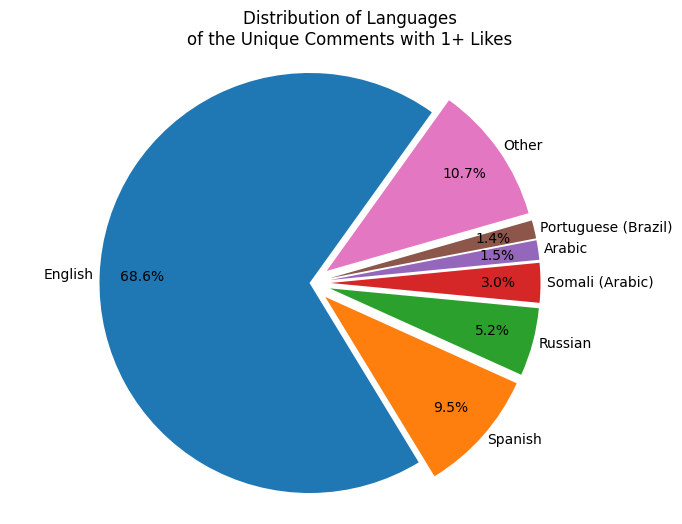

In [7]:
# Pie Chart of Distribution of Languages of the Unique Comments with 1 or more Likes

# Top Languages to show
language_map_comments = {
    "en": "English",
    "es": "Spanish",
    "ru": "Russian",
    "so": "Somali (Arabic)",
    "ar": "Arabic",
    "pt": "Portuguese (Brazil)",
}

# Get the count per language. Combine less common languages into "Other"
# Note: This is the count of unique comments with 1+ likes
#   We already removed duplicate texts and comments with 0 likes
language_counts = translated_comments['Language'].replace(language_map_comments).value_counts()
top_languages_comment = language_counts.nlargest(len(language_map_comments))
other_count = language_counts.iloc[len(language_map_comments):].sum()
top_languages_comment['Other'] = other_count

# Define the color scheme (will additionall be used for the next pie chart)
common_languages = top_languages_comment.index
color_map = plt.get_cmap("tab10")(range(len(common_languages)))
color_dict = dict(zip(common_languages, color_map))

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
explode = [0] + [0.1]*len(language_map_comments)
top_languages_comment.plot.pie(
    ax=ax,
    startangle=54.36,
    explode=explode,
    labeldistance=1.03,
    autopct="%.1f%%",
    pctdistance=0.80
)
ax.set_ylabel('')
fig.suptitle("Distribution of Languages\nof the Unique Comments with 1+ Likes", x=0.55, y=0.95)
ax.axis('equal')
plt.show()

#### Pie Chart of Total Likes per Language
* We can view the distribution of likes for each language
    * The previous operations preserve the likes per language
    * Note: This is the data after combining identical raw texts but before combining translated texts
        * So "Hello" and "Hello" count as 1 English comment. "Hello" and "Hola" count 1 for English and 1 for Spanish
* ~97% of all likes are on English comments
    * This means that even if translation from other languages to English aren't perfect, it is a small amount of the mass anyway
    * This could mean that the "wonky" translations are something to look into in the future. There might actually be more lost than gained if enough of the English comments have "wonky" translations
        * A "wonky" translation is when an English comment get labeled as some other language then is incorrected translated 'back' into English. Ex:
            * Original: &emsp;*Maaacck!!...MUAAAACCK* !! - Arnold Schwarzenegger (Tahitian detected)
            * Translated: *Maaacck!! ... MUAAAACCK* - Arnold Arnold Arnold
* The language with the 2nd most likes was Spanish with 1.1%
* The language with the 3rd most likes was Russian with 0.5%
    * Adding Russian to the chart begins to make it less readable
    * Adding anything less common than Russian continues to make it less and less readable

~97% of likes are on English comments but only 70% of unique comments with 1 or more likes was English
* This isn't totally surprising since the primary language of the video is English
* This could also be that there were a lot of repeat comments in English which got combined in an earlier step
    * Imagine a scenario where there are only 50k possible unique comments, and the language is randomly selected
        * So for each unique comment, it can be posted in any language (with 10 languages, that would mean 500k total unique comments possible)
            * The comments are sampled from the 50k with replacement
        * The language is a weighted distribution with English being selected something like 95% of the time
        * If we had 1k comments in that scenario and did the same combining of comments, English would have nearly 95% of all comments since there aren't many repeats
        * If we had an arbitarily large number of comments (100 billion for example), all languages would have at least 1 instance of each comment, so after combining identical comments the "Distribution of Languages of the Unique Comments with 1 or more Likes" would have each language equally represented (50k for each language)
        * We have ~215k comments, which is somewhere between a very small and very large number of comments. English therefore makes a large portion of the distribution, but not as much as the un-combined comments
        * I believe in essence something similar to this situation has occurred which has led to English comments having 97% of likes, but only 70% of unique comments are English

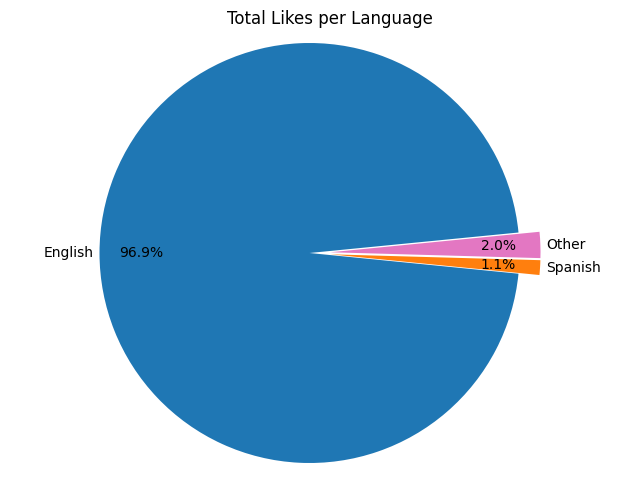

In [8]:
# Pie Chart of Total Likes per Language
language_map_likes = {
    "en": "English",
    "es": "Spanish",
}

# Get the count of likes per language. Combine less common languages into "Other"
# Note:
#   We preserved likes when removing duplicate texts and only removed comments with 0 likes
#   So the count of likes per language is the same here as it would be before those two operations
likes_per_language = translated_comments.groupby('Language')['Likes'].sum()
likes_per_language = likes_per_language.sort_values(ascending=False)
likes_per_language = likes_per_language.rename(index=language_map_likes)
top_languages_likes = likes_per_language.nlargest(len(language_map_likes))
other_likes = likes_per_language.iloc[len(language_map_likes):].sum()
top_languages_likes['Other'] = other_likes

fig, ax = plt.subplots(figsize=(8, 6))
explode = [0] + [0.1]*len(language_map_likes)
likes_colors = [color_dict[lang] for lang in top_languages_likes.index]
top_languages_likes.plot.pie(
    ax=ax, 
    startangle=5.6, 
    explode=explode,
    labeldistance=1.03, 
    autopct="%.1f%%", 
    pctdistance=0.80, 
    colors=likes_colors
)

ax.set_ylabel('')
fig.suptitle("Total Likes per Language", x=0.525, y=0.90)
ax.axis('equal')
plt.show()

#### Histograms of Lengths
* We can view the distribution of text lengths based on word count, character count, and tokenized length
* The vast majorioty of comments are shorter than 20 words. The vast majorioty of comments are less than 111 characters. The vast majorioty of comments are less than 29 tokens.

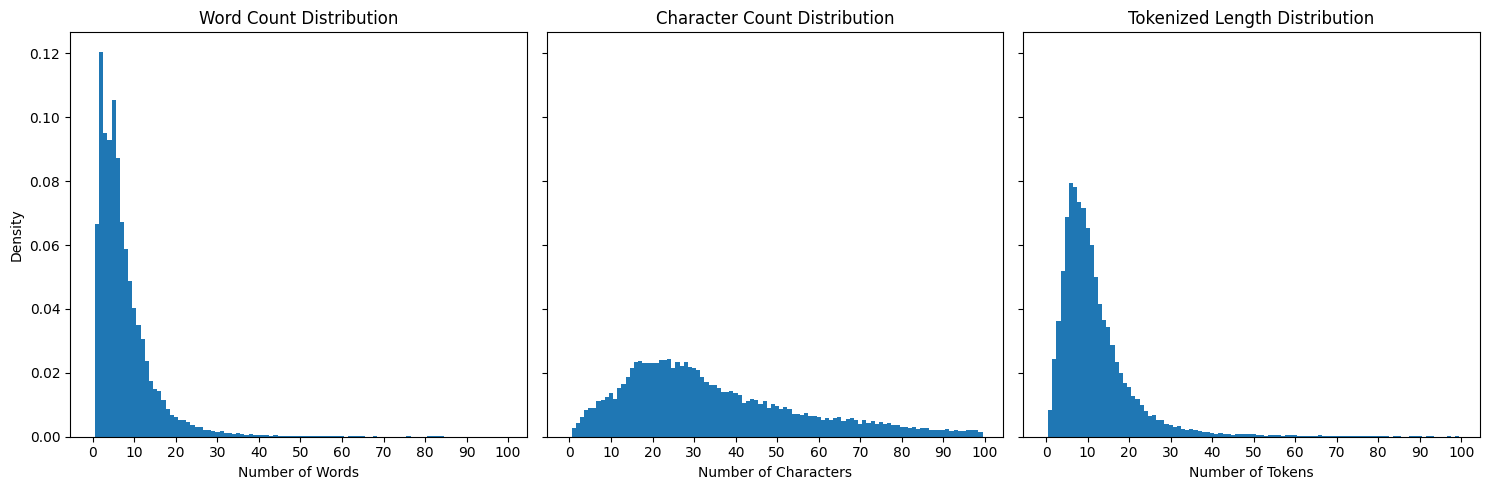

95% of comments have less than 20.0 words
95% of comments have less than 111.0 characters
95% of comments have less than 29.0 tokens


In [9]:
# Histograms of Lengths

# Calculate text statistics
word_counts = final_comments["English Text"].apply(lambda x: len(x.split()))
char_counts = final_comments["English Text"].apply(len)
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_ID)
token_lengths = [len(tokenizer.encode(comment)) for comment in final_comments["English Text"]]

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
num_bins = 101
tick_step = 10

# Word Count Histogram
axes[0].hist(word_counts, bins=np.arange(num_bins) - 0.5, density=True)
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Density")
axes[0].set_xticks(np.arange(0, num_bins + 1, tick_step))

# Character Count Histogram
axes[1].hist(char_counts, bins=np.arange(num_bins) - 0.5, density=True)
axes[1].set_title("Character Count Distribution")
axes[1].set_xlabel("Number of Characters")
axes[1].set_xticks(np.arange(0, num_bins + 1, tick_step))

# Tokenized Length Histogram
axes[2].hist(token_lengths, bins=np.arange(num_bins) - 0.5, density=True)
axes[2].set_title("Tokenized Length Distribution")
axes[2].set_xlabel("Number of Tokens")
axes[2].set_xticks(np.arange(0, num_bins + 1, tick_step))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

print(f"95% of comments have less than {np.percentile(word_counts, 95)} words")
print(f"95% of comments have less than {np.percentile(char_counts, 95)} characters")
print(f"95% of comments have less than {np.percentile(token_lengths, 95)} tokens")

#### Histogram of Number of Likes
* There are ~1.1M likes between all 33k comments.
* Looking at the histogram, we see most of the comments have only a few likes
    * The most liked 100 comments are omitted from the histogram to make it more readable
    * The comment with the most likes is MrBeast's pinned comment with ~114k likes
        * There are only 10 comments with more than 10k likes. These 10 comments have ~330k likes total (31% of all comment likes)
        * There are only 25 comments with more than 5k likes. These 25 comments have ~430k likes total (40% of all comment likes)
        * There are only 100 comments with more than 1600 likes. These 100 comments have ~630k likes total (59% of all comment likes)
* Note: Comments with 0 likes were removed in a previous step
* Note: comments with the same English text were combined in a previous step
    * If the comments "Hello" and "Hola" each had 15 likes (and there was no other version of "Hello"), this would appear on the histogram as 1 comment with 30 likes

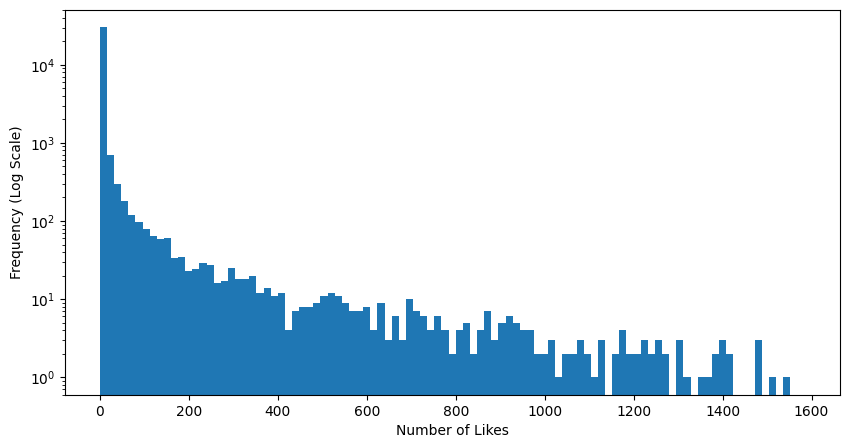

In [10]:
# Histogram of Number of likes
plt.figure(figsize=(10, 5))
plt.hist(final_comments["Likes"], bins=np.arange(0, 1600, 16), log=True)
plt.xlabel("Number of Likes")
plt.ylabel("Frequency (Log Scale)")
plt.show()

#### Cumulative Distribution of Likes
* An alternative visualization of the histogram of number of likes is the cumulative distribution of likes
* Looking at the cumulative sum of likes vs number of top comments:
    * The top 1 comment has ~11% of all comment likes
    * The top 1% of comments have 77% of all comment likes
    * The top 2% of comments have 86% of all comment likes
    * The top 5% of comments have 93% of all comment likes
    * The top 10% of comments have 96% of all comment likes
* Note: Comments with 0 likes were removed in a previous step
* Note: comments with the same English text were combined in a previous step
    * If the comments "Hello" and "Hola" each had 15 likes (and there was no other version of "Hello"), this would count as 1 comment with 30 likes

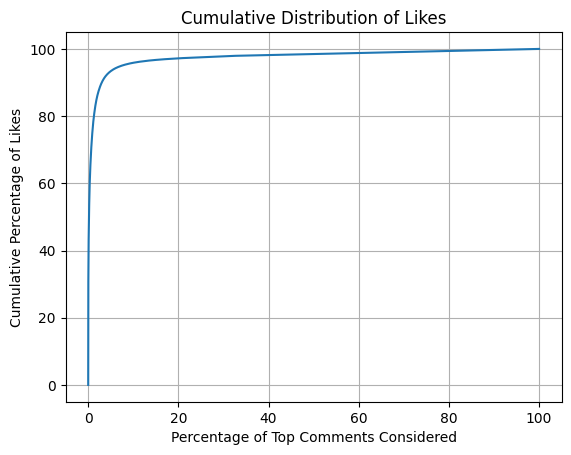

In [11]:
# Cumulative Distribution of Likes
sorted_likes = final_comments["Likes"].sort_values(ascending=False).to_numpy()
cumulative_likes = np.cumsum(sorted_likes) / sum(sorted_likes)
cumulative_likes = np.insert(cumulative_likes, 0, 0.0) * 100

plt.plot(np.linspace(0, 100, len(cumulative_likes), endpoint=True), cumulative_likes)
plt.grid()
plt.xlabel("Percentage of Top Comments Considered")
plt.ylabel("Cumulative Percentage of Likes")
plt.title("Cumulative Distribution of Likes")
plt.show()

### Embedding
* We need some kind of embedding model to cluster the text of the comments
    * An embedding is just a vector. The goal is that the vector captures semantic similarities so comments with similar meanings are close together even if the actual words used are very different
* To get an embedding, I use an embedding model
    * An embedding model is just a model that takes in text (or tokenized text) and outputs an embedding
    * This model is not trained on our data, but we hope the data it was trained on is similar enough that it will group similar comments near each other
* Researchers at Hugging Face published a set of benchmark tasks for embedding models, "MTEB: Massive Text Embedding Benchmark"
    * There are just over 100 datasets divided between a number of tasks
* MTEB has a clustering task, and has several datasets for clustering
    * Unfortunately, the only "web domain" data is from Stack Exchange which is not exactly apples-to-apples with our dataset of YouTube comments but is likely close enough
    * There are other data sources from internet (as opposed to new articles, legal documents, research papers, etc). Those other data sets are even less similar to YouTube comments (I.e. Wikipedia or other encyclopedic, non-fiction, type sources).
* Hugging Face has a leaderboard of the performance of all the models they tested, and allows for researchers to publish the results of new models. I ranked all open source models by the performance on the clustering task on the Stack Exchange dataset
    * The top 2 performing models (as of the time of writing this) are gte_Qwen1.5-7B-instruct and gte-Qwen2-7B-instruct with scores of 80.60 and 80.26 respectively
    * The scores are likely close enough that the Stack Exchange clustering alone could not definitively tell us which model would be better on our dataset of YouTube comments
    * Given that, I have chosen to use the Qwen2 model as it generally has better performance than the Qwen1.5 model on most tasks
* Note: The embeddings are normalized by the Qwen2 model to have length 1

In [12]:
if os.path.exists(DOCUMENT_EMBEDDINGS_PATH):
    embeddings = np.load(DOCUMENT_EMBEDDINGS_PATH)
else:
    model = SentenceTransformer(EMBEDDING_MODEL_ID, trust_remote_code=True)
    model.max_seq_length = EMBEDDING_MAX_LENGTH
    embeddings = model.encode(final_comments["English Text"].tolist(), batch_size=1, show_progress_bar=True)
    np.save(DOCUMENT_EMBEDDINGS_PATH, embeddings)
    del model

### Dimensionality Reduction
* Clustering algorithms, and especially density based clustering algorithms, generally don't work well is very high dimensional spaces
    * The embedding model outputs a 3584 dimensional vector for each comment
* We ideally want to reduce the dimensionality of the data without losing much information
* PCA is a linear method for dimensionality reduction
    * We won't actually be using PCA for dimensionality reduction, but PCA can give us some insight into the trade-off of dimensionality reduction vs information loss
        * Explained variance approximates "information loss" in this case
    * The cumulative distribution of explained variance vs number of dimensions shows us that the first few dimensions can explain most of the variance
        * A 36 dimensional representation of the original embeddings has 1% the number of dimensions but can explain 55% of variance
    * We can preserve 80% of the explained variance with 217 dimensions
        * For 90%, we would need to jump all the way up to 538 dimensions
* UMAP is a non-linear method for dimensionality reduction that claims to preserve both local and global structures in the data
    * UMAP is often used as a preprocessing step for clustering tasks because it has nice properties when given complex data
        * It generally preserves local structure and projects similar points near each other
        * It generally preserves global structure, so different clusters are well separated
        * It can have noise reducing properties
    * UMAP isn't perfect, and there are valid criticisms of it
    * UMAP will be used as the dimensionality reduction method for this demo
* UMAP requires n_neighbors, n_components, and min_dist as parameters
    * n_neighbors determines the balance between local vs global features
        * This analysis is looking for broad, main themes
        * I use a value of 30 which should balance both local and global structure, but possibly leaning more towards global structure
    * n_components is the dimensional space of after reduction
        * I use 217 which is an informed guess from PCA
    * min_dist is the closest distance that points can be packed together in the new space
        * Since we want high density clusters, we set min_dist to 0.0 to allow UMAP to pack the points tightly
* Since we are still using a relatively high dimensional space, I use the cosine metric instead of Euclidean or others
* Dimensionality reduction hyper parameter selection can be informed by intuition, but can often boil down to "try it and see if it works"
    * If the clustering did not yield meaningful, semantically similar clusters then I would try different parameters until it does find meaningful clusters
    * If it continues to not yield meaningful clusters, I would continue iterating until I feel I've exhausted what I expect to be the useful region of the hyper parameter search space

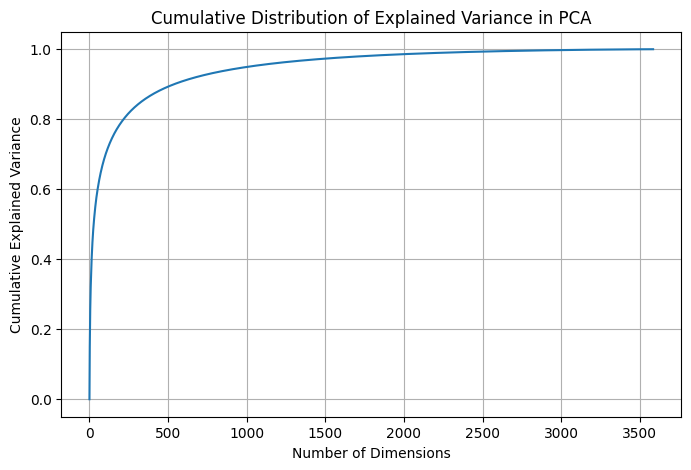

In [13]:
# Compute cumulative explained variance from PCA
pca = PCA()
pca.fit(embeddings)
explained_variance_first = np.cumsum(pca.explained_variance_ratio_)
explained_variance_first = np.insert(explained_variance_first, 0, 0.0)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(0, len(explained_variance_first)), explained_variance_first)
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Distribution of Explained Variance in PCA")
plt.grid()
plt.show()

In [14]:
# Hyperparameter - Choose the minimum number of dimensions that explains 80% of the variance
EXPLAINED_VARIANCE_FIRST = 0.8
n_components_first = np.argmax(explained_variance_first >= EXPLAINED_VARIANCE_FIRST)

# Hyperparameter - Min Samples is twice the number of dimensions
MIN_SAMPLES_FIRST = 2 * n_components_first

In [15]:
# We want the number of dimensions that explains 80% of the explained variance (217 dims)
# min_dist is 0.0 so get points clustered as closely together as possible
# n_neighbors of 30 balances local and global structures
# 217 is still a high dimensional embedding, so we use cosine for our metric
# use a random state for repeatability, and n_jobs=1 because the UMAP does not allow parallelism when seeded
umap_model = UMAP(
    n_components=n_components_first,
    min_dist=0.0,
    n_neighbors=30,
    metric='cosine',
    random_state=42,
    n_jobs=1 # UMAP does not allow parallelism when seeded
)
dim_reduced_embeddings = umap_model.fit_transform(embeddings)

/home/ncalifan/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Clustering
* We will use DBSCAN for clustering to find regions with high density
* DBSCAN has two parameters: eps and min_samples
    * eps is the distance between points that we define to be "neighbors"
        * Larger distance means less points are "neighbors" and clusters are harder to form
        * Smaller distance means more points are "neighbors" and clusters are easy to form, but also easier to combine into very large (and therefore likely non-meaningful) clusters
        * To determine eps, I use the Kneedle Method (Finding a "Kneedle in a Haystack: Detecting Knee Points in System Behavior")
            * The Kneedle Method uses the idea that we can get a gauge on the value of eps by looking at the distance between points in our embedding space
            * Each "distance" is the distance from one point to its K-th nearest neighbor
                * K can be taken to be value used for min_samples (2 * dimensionality of embedding)
            * We can sort the distances and plot them with the x-value being the index and the y-value being the distance
            * There should be an "elbow" or a "knee" in the plot
                * This method is a part of a broader set of methods known as "Elbow Methods" or "The Elbow Method"
            * Kneedle Method
                * The Kneedle Method begins by plotting an imaginary line from the start of the curve to the end of the curve
                * The "knee" is then the point on the curve that is farthest from that line
            * This is obviously not going to be optimal in any way, but we have to make some kind of educated guess for eps
    * min_samples is the minimum number of samples that need to be "neighbors" in order for a new cluster to be created
        * For min_samples, I simply use 2 times the dimensionality of the embedding space (after dimensionality reduction)
            * This is likely a low value since we then use the number of likes as sample weight
            * This value was not tuned very much but gave good results anyway

In [16]:
# Kneedle Method
def kneedle(n_neighbors, embeddings, plot=False):
    # For each point, get the distance to its K-th nearest neighbor
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine").fit(embeddings)
    distances, __ = nbrs.kneighbors(embeddings)
    dist_sorted = sorted(distances[:, distances.shape[1] - 1], reverse=True)

    # Consider the distances curve
    # Find the distance from the distances curve to the straight line that connects the start and end of that curve
    #   This is the difference curve
    endpoint_line = np.linspace(dist_sorted[0], 0, len(distances), endpoint=True)
    dist_difference = endpoint_line - dist_sorted

    # Find the maximum of the difference curve. That point is the elbow/knee
    max_difference_idx = np.argmax(dist_difference)

    # Plot the distances curve and the difference curve
    plt.plot(dist_sorted, label="K-NN Distance")
    plt.plot(dist_difference, label="Difference")
    plt.scatter(max_difference_idx, dist_sorted[max_difference_idx])
    plt.scatter(max_difference_idx, dist_difference[max_difference_idx])
    plt.legend()
    plt.show()

    # Elbow is the max difference
    return dist_sorted[max_difference_idx]

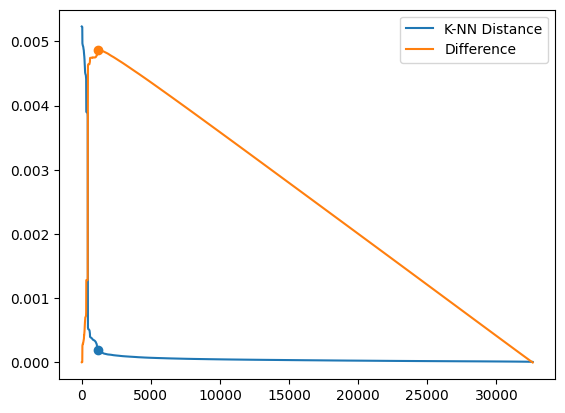

In [17]:
elbow_dist = kneedle(MIN_SAMPLES_FIRST, dim_reduced_embeddings, plot=True)
clusterer = DBSCAN(
    eps=elbow_dist,
    min_samples=MIN_SAMPLES_FIRST,
    metric="cosine"
)

clustering = clusterer.fit(
    dim_reduced_embeddings,
    sample_weight=final_comments["Likes"]
)

In [18]:
# Create a DataFrame that includes the clustering information
clustered_comments = final_comments.copy()
clustered_comments["First Cluster"] = clustering.labels_

In [19]:
def calculate_intra_cluster_variance(cluster_embeddings):
    """ Calculates the intra-cluster variance for a given cluster """
    centroid = np.mean(cluster_embeddings, axis=0)
    variance = np.sum((cluster_embeddings - centroid) ** 2)
    return variance / len(cluster_embeddings)

### Results of First Clustering

The first pass at clustering allows us to find several meaningful clusters, and will let us remove ~8k of the ~33k points when we do a second pass. Hopefully those ~8k were acting as "noise" and when we clustering just the remaining samples it results in more meaningful clusters (Spoiler Alert: Our hopes came true in the next clustering found meaningful clusters).

Unfortunately, most of the comments get grouped into clusters 0 and 1 and therefore those two clusters weren't particularly meaningful. Cluster 8 seems to be in a similar situation where it didn't have a coherent meaning, but it is much smaller. The other clusters (2 through 7) are well segmented and have low intra-cluster variance, which can easily be confirmed by manually reviewing samples from clusters. Within each of those clusters, the comments are incredibly simple and nearly identical, so a more advanced topic modeling technique is unncessary.

Cluster 0 & 1: Huge and diverse
* Based on a reading a sample of comments in each of these clusters, each of these have many topics inside them
    * This is evident by the top comments, but was confirmed by skimming more comments

Clusters 2, 3 & 6: Mythpat Bhai (42k likes)
* These 3 clusters all relate to "Mythpath Bhai". They often have the same phrase then have exclamation points and/or emojis
    * Cluster 2 is "Mythpat Bhai"
    * Cluster 3 is "Mythpath Bhai x Mr Beast"
    * Cluster 6 is "Mission Mythpat Bhai"
* Mythpath Bhai is name of another YouTuber and he voiced the Hindi dub of the video
* I would speak to our stakeholders to confirm this

Cluster 4: Comments generally refer say "Give him another chance" (52k Likes)

Cluster 5: Fede Vigevani (7k Likes)
* This cluser refers to Fede Vigevani's dub of the video
* It seems to include a small number of comments with a more generic reference to dubbing as well
* Includes several mentions of Klingon - Fede's dubbing of the video is labeled "Klingon"
    * This would also be something to run past stakeholders. Some quick research showed this is not the first time Fede's dub of a video has been labeled Klingon. I'd have some questions around this.

Cluster 7: Same text repeated 9 times (4k likes). Text:<br />
&emsp;M - Mighty in perseverance<br />
&emsp;A - Always fearless<br />
&emsp;C - Courageous and relentless<br />
&emsp;K - Keep pushing forward<br />

Cluster 8: Generally about Mack, hard to immediately see any overarching topic

Noise (Cluster -1): Most comments are related to "Khatron Ke Khiladi" which seems to be an Indian version of Fear Factor. There are also a small number of "Mythpat" related comments.

In [20]:
cluster_labels = [idx for idx in clustered_comments["First Cluster"].unique() if idx != -1]

NUM_TOP_LIKED_SHOW = 5
for cluster_label in cluster_labels:
    # Get indices of points in the current cluster
    cluster_idxs = np.where(clustered_comments["First Cluster"] == cluster_label)[0]
    
    # Get the subset of the DataFrame for the cluster
    cluster_df = clustered_comments.iloc[cluster_idxs]
    
    # Select the most liked comments in the cluster
    top_liked = cluster_df.nlargest(NUM_TOP_LIKED_SHOW, "Likes")

    intra_cluster_variance = calculate_intra_cluster_variance(dim_reduced_embeddings[cluster_idxs])

    print(f"Cluster {cluster_label}: {len(cluster_idxs)} comments | {sum(cluster_df["Likes"])} likes | {np.round(intra_cluster_variance, 2):.2f} intra-cluster variance")

    # Print the most liked comments
    for _, row in top_liked.iterrows():
        print(f"- ({row['Likes']} likes) {row['English Text']}".replace("\r", "").replace("\n", " "))
    print()

# Print the number of noise points
noise_count = (clustered_comments["First Cluster"] == -1).sum()
print(f"Number of Noise Points: {noise_count}")

Cluster 0: 18939 comments | 539673 likes | 7.57 intra-cluster variance
- (114454 likes) The new Feastables bars will take some time to hit shelves! Should be in every Walmart right now and give the other retailers some time to get the new product ❤
- (24582 likes) This is the saddest thing I've seen this month.  Give this man another chance
- (18022 likes) Bro was tortured and then went home with nothing An Absolute legend
- (16041 likes) The way he did the sinking car challenge alone deserves 800k
- (15373 likes) We need this guy back. It's too heartbreaking watching him preserve and still end up empty handed.

Cluster 1: 5365 comments | 420993 likes | 1.22 intra-cluster variance
- (81519 likes) Mack's determination and resilience are truly inspiring. He deserves all the success that comes his way.
- (24062 likes) Mack has every right to become a villain.
- (14480 likes) Lets give Mack a 3rd chance hes deserves it
- (8415 likes) We need another episode to complete the Mack trilogy, fo

### Second Clustering

For the next pass of clustering, I ignore samples that are well segmented based on the first pass of clustering. I.e. the samples in clusters 2 through 7.

I perform a similar dimensionality reduction, but only using only the samples of interest so the mappings are better tuned to the remaining samples.

I found that DBSCAN did not perform well on this subset of the data. Tuning the hyperparameters it tended to do one of the following: label everything noise, label a substantial proportion noise and create 1-2 large clusters, or label nothing noise and create 1-2 large clusters. I performed hyperparameter tuning on UMAP's n_components and n_neighbors as well as DBSCAN's eps and min_samples. There were a small subset of hyperparameters that would have ~6 clusters. But the clusters didn't seem to be particularly meaningful. This may be because the first round of clustering found all the high density clusters and DBSCAN looks for high density volumes to seed clusters, so there were just no more for it to find.

After DBSCAN didn't work, I turned to K-means clustering. Sklearn's implementation of K-means doesn't support weighted samples, so I just repeated samples based on the number of likes. I found that the raw number of likes was not for the sample weightings. When using the raw number of likes, the center of N clusters essentially becomes the locations of the top N comments. The clusters then lose meaning because they are severely overfit on the most liked samples. To adjust this, I created a sublinear weighting function. The idea behind it is that we still want the number of likes to guide the clusters, but not directly proportionally. The sublinear function is linear from 1 to 10 (thanks to integer rounding) but then diverges more and more from a linear function. A comment with 100 likes has a weight of 62. The most liked comment has 114k likes, but only has a weight of 607. Using this method led to meaningful clusters around relatively coherent and explainable topics. If the sublinear weighting function led to non-meaningful clusters or incoherent topics, I'd investigate not performing sample weighting at all.

After experimenting with setting the number of clusters between 10 and 100, I found that 40 gave interpretable results. There were still some clusters that might benefit from being split, and some clusters that were too small (less than 20 comments). However, it felt relatively easy to identify salient topics in the clusters by looking at the most liked comments of the cluster, comments near the centroid of the cluster, and the top TF-IDF topics (discussed below). By skimming many comments from each cluster, I was able to confirm that the labels I give are generally representative of the entire cluster. The purpose of clustering was to find trends in the comments without having to read tens of thousands of comments and then manually define topics and assign comments to the topics. While 40 clusters is still quite a bit of work to go through, it is at least manually tractable. If we needed many more clusters (say 400 instead of 40), I would have implemented other tricks to combine clusters.

In [21]:
# Create a subset of the data based on the results of the first clustering
second_cluster_idxs = np.where(np.isin(clustered_comments["First Cluster"], [0, 1, 8]))[0]
embeddings_second_cluster = embeddings[second_cluster_idxs]
comments_second_cluster = clustered_comments.iloc[second_cluster_idxs]

In [22]:
# Dimensionality Reduction

# Compute cumulative explained variance from PCA
pca = PCA()
pca.fit(embeddings_second_cluster)
explained_variance_second = np.cumsum(pca.explained_variance_ratio_)
explained_variance_second = np.insert(explained_variance_second, 0, 0.0)

# Hyperparameter - Choose the minimum number of dimensions that explains 80% of the variance
EXPLAINED_VARIANCE_SECOND = 0.8 # This is the same as the first clustering's dimensionality reduction, but it doesn't have to be
n_components_second = np.argmax(explained_variance_second >= EXPLAINED_VARIANCE_SECOND)

umap_model = UMAP(
    n_components=n_components_second,
    min_dist=0.0,
    n_neighbors=5,
    metric='cosine',
    random_state=42,
    n_jobs=1, # UMAP does not allow parallelism when seeded
    low_memory=True
)
dim_reduced_embeddings_second_cluster = umap_model.fit_transform(embeddings_second_cluster)

/home/ncalifan/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [23]:
def sublinear_like_weighting(likes):
    """ A sublinear function to modify the weighting of likes """
    # From 1 to 10, the weight is linear (thanks to integer rounding)
    # From 10 to 100, the weight begins to be more nonlinear (f(100) = 62)
    # After 100, the function is highly sublinear. (f(100k) = 586)
    denom = np.power(likes+100, 0.75)
    return np.rint(33 * likes / denom).astype(int)

# For K-means clustering, we need to repeat the samples based on the number of Likes
#   We are only using the samples in clusters 0, 1 and 8 from the first round of clustering.
#       We use the reduced dimensionality embeddings: dim_reduced_embeddings_second_cluster
# Create a copy of the embeddings with repeated samples
#       This is again the reduced dimensionality embeddings: dim_reduced_repeated_embeddings
# There are N samples in dim_reduced_embeddings_second_cluster, so dim_reduced_repeated_embeddings will have N unique values
#   To make it easy to map back to the original dataframe, dim_reduced_repeated_embeddings[:N] = dim_reduced_embeddings_second_cluster
indices = np.arange(len(comments_second_cluster))
sample_weights = sublinear_like_weighting(comments_second_cluster["Likes"])
repeated_indices = np.hstack([np.full(count - 1, i) for i, count in enumerate(sample_weights) if count > 1])
weighted_indices = np.concatenate([indices, repeated_indices])
dim_reduced_repeated_embeddings = dim_reduced_embeddings_second_cluster[weighted_indices]

# Perform clustering and get the labels
NUM_K_MEANS_CLUSTERS = 40 # Hyperparameter
kmeans = KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, random_state=42, n_init=100)
kmeans_clustering = kmeans.fit(dim_reduced_repeated_embeddings)
clustered_comments.loc[second_cluster_idxs, "Second Cluster"] = kmeans_clustering.labels_[:len(second_cluster_idxs)]

### Topic Modeling

The topic(s) of these new clusters were not always as immediately clear. We can use TF-IDF to try to find topics (which will guide our manual review of samples).

TF-IDF has two terms Term Frequency (TF) and Inverse Document Frequency (IDF).
* TF-IDF finds "topics". A topic is just an ngram in this case. I use ngrams of length 2 and 3 because ngrams of length 1 were often noisy and ngrams longer than 3 didn't score well.
* The TF term measures how often a topic appears in a comment. Normally each time the topic appears in a document the TF term increases by 1. However, since the comments are so short, I use binary TF which just means 0/1 for "does this topic appear in this comment at least once".
    * "Mack Mack Mack!" has the topic "Mack" just as much as "Mack!". It doesn't make sense to count the former as 3x the weight as the latter.
* IDF is a normalization measure. Certain topics like "he was" are going to appear in many comments. The IDF normalizes those topics to make the TF-IDF an importance measure rather than just a simple count.
* As an example, if you run the TF-IDF on Shakespeare's 37 plays:
    * You'll find the word "Romeo" only appears in one play, but it appears 130 times. So the word "Romeo" is both only present in a small number of documents (only 1 in this case), but it comes up a lot in that play. So its TF-IDF score is very high, and it should have a large score.
    * The word "Falstaff" appears 116 times across 4 plays, and in one play appears 46 times. This would have a lower, but still quite high score.
    * The word "fool" appears 400 times across 36 of the 37 plays. The most it appears in any one play is 35 times, which is nearly the same as "Falstaff". However, since the word "fool" appears in almost every play, it is just a word that Shakespeare likes. It is not a topic of any of those plays and thus should score relatively low.

To get the topics of each cluster, we can perform the IDF step on all comments, then perform the TF step on just the current cluster. Then we can sum the TFs across the comments of the current cluster and get the TF-IDF score of this cluster normalized across all comments.

TF-IDF can have a problem with noise. To combat noise, we only consider a topic if it appears in more than 20 comments, but less than 10% of all comments (something like "he is" might appear in many comments so we can ignore it). We also don't want to consider stop words like "the", "a", "on", etc. There are some other tricks like lowercasing that are used as well.

### Results

I used the most liked comments, comments near the centroid, and highest scoring TF-IDF topics to inform the topic of the cluster. I would then confirm that the topic was representative of the cluster by skimming many random comments from that cluster. For each cluster, I found the salient topic and grouped similar clusters together (there were obvious groupings). If we had many clusters or more complex data, I could be smarter about automatically combining clusters.

To create categories and topics, we originally assumed that each comment has 1 topic, and that 1 topic fits nicely into a single high level category. There were some comments, notably those in clusters 15 and 23, that broke this assumption could be assigned to multiple categories. Assigning a comment to multiple categories is a slightly more complex and more involved analysis. Methods like Latent Dirichlet Allocation or Gaussian Mixture Models would be able to assign comments to multiple categories. But the simple K-means clustering cannot. Moving clusters 15 and 23 from counting towards one categorization vs the other wouldn't change high level categories, and wouldn't even really change the ranking of the high level categories based on total number of likes. It definitely doesn't change any of the final conclusions or outcomes. If I presented this to our stakeholders and they wanted us to revisit this, then that is totally acceptable and we would just need to use a slightly different method.

I am defining "noise" to be any comment that is a direct quote from the video as well as any comment that is generic enough that it could have been on most MrBeast videos and it would still make sense.
<br />Examples:
* 20:40 Insane
* Who's watching from Africa?
* So sad! Can't believe it
* At least give him $100k
* "Mack stop breaking my set!"

#### Main Topics and Associated Clusters
Variant of "Give Mack Another Chance" (567k Likes)
* Cluster  0 - "Mack deserved another try"
* Cluster  2 - "This guy deserves another chance"
* Cluster  4 - "Jimmy, give Mack another chance"
* Cluster  5 - "Give him another chance" in a sentence with the word "challenge"
* Cluster 12 - "PLEASE give mack one more try. He’s so determined it’s inspiring"
* Cluster 15 - "Give him another chance, the underwater challenge was crazy"
* Cluster 16 - "One more chance"
* Cluster 19 - "Give him another chance"
* Cluster 21 - "He should come back"
* Cluster 22 - "Justice for Mack, he deserved a 3rd chance"
* Cluster 29 - "Give Mack another chance"
* Cluster 31 - "Give this man another chance"

Other Mack (117k Likes)
* Cluster  6 - "Mack should join the Mr Beast crew"
* Cluster 10 - "Mack is the best contestant"
* Cluster 13 - "Mac _"
* Cluster 17 - "Mack is _"
* Cluster 23 - "Mack deserves _" (sometimes but not frequently _ is "another chance")
* Cluster 25 - "Mack is about to become a villain"

Video Challenges (64k Likes)
<br />(The video was composed of several challenges that Mack had to complete to win, the last of which involved cookies)
* Cluster 14 - Cookie Challenge
* Cluster 38 - Challenges: "Squid Game" and "Faced Fear"
* Cluster 39 - Cookie Challenge
* Note: Cluster 15 could also go here

Feastables ~116k Likes
* Cluster 27 - Feastables/Chocolate

Fede (0.3k Likes)
<br />(Fede as in Fede Vigevani which was a cluster from the first clustering. Fede is incorrectly translated to "Faith" in many of these comments.)
* Cluster 28 - Fede

Noise (102k Likes)
* Cluster  1 - Timestamps
* Cluster  3 - Mr Beast
* Cluster  7 - Country Related ("Greetings from Peru")
* Cluster  8 - 16:24 Chandler's Reaction
* Cluster  9 - Seemingly unrelated comments
* Cluster 11 - All about money (the prize was $800k)
* Cluster 18 - "Fear"
* Cluster 20 - Seemingly unrelated comments
* Cluster 24 - 15 comments of "Matt stop breaking my set" (Quote in the video from MrBeast)
* Cluster 26 - 8 total comments of "Bro's dad lore is gonna be insane"
* Cluster 30 - Emojis and/or Yesssss/Noooooo
* Cluster 32 - Seemingly unrelated comments
* Cluster 33 - 1 comment: "Who is Hindu?"
* Cluster 34 - Palestine
* Cluster 35 - So sad
* Cluster 36 - "Anyone in _" (Blank is November, December, etc)
* Cluster 37 - Seemingly unrelated comments

In [24]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=0.10,
    min_df=20,
    ngram_range=(2, 3),
    binary=True,
    stop_words='english',
    strip_accents="unicode",
    lowercase=True,

)

# Fit the idf step on the entire document corpus
vectorizer.fit(clustered_comments["English Text"].tolist())
feature_names = vectorizer.get_feature_names_out()

In [25]:
cluster_labels = [idx for idx in clustered_comments["Second Cluster"].unique() if idx != -1 and not np.isnan(idx)]
cluster_labels.sort()

cluster_centers = kmeans.cluster_centers_
comments_second_clustering = clustered_comments.iloc[second_cluster_idxs]

NUM_TOP_LIKED_SHOW = 5
NUM_CENTROID_SHOW = 5
NUM_TOPICS_SHOW = 5
for cluster_label in np.sort(comments_second_clustering["Second Cluster"].unique()):
    # Get indices of points in the current cluster
    cluster_mask = comments_second_clustering["Second Cluster"] == cluster_label
    cluster_idxs = np.where(cluster_mask)[0]
    cluster_embeddings = dim_reduced_embeddings_second_cluster[cluster_idxs]

    # Get the subset of the DataFrame for the cluster
    cluster_df = comments_second_clustering.iloc[cluster_idxs]

    intra_cluster_variance = calculate_intra_cluster_variance(cluster_embeddings)
    print(f"Cluster {int(cluster_label)}: {len(cluster_idxs)} comments | {sum(cluster_df['Likes'])} likes | {np.round(intra_cluster_variance, 2):.2f} intra-cluster variance")

    # Print the most liked comments
    print("Top Comments")
    top_liked = cluster_df.nlargest(NUM_TOP_LIKED_SHOW, "Likes")
    for _, row in top_liked.iterrows():
        print(f"\t- ({row['Likes']} likes) {row['English Text']}".replace("\r", "").replace("\n", " "))

    # Get the comments closest to the cluster centroid
    print("Centroid Comments")
    cluster_center = cluster_centers[int(cluster_label)]
    cluster_distances = 1 - cosine_similarity(cluster_embeddings, cluster_center.reshape(1, -1)).flatten()
    closest_idx = cluster_idxs[np.argpartition(cluster_distances, -min(len(cluster_distances), NUM_CENTROID_SHOW))[-NUM_CENTROID_SHOW:]]
    centroid_comments = comments_second_clustering.iloc[closest_idx]
    for _, row in centroid_comments.iterrows():
        print(f"\t- {row['English Text']}".replace("\r", "").replace("\n", " "))

    # Compute TF-IDF for this cluster
    print("Top Topics")
    cluster_tfidf = vectorizer.transform(cluster_df["English Text"].tolist())
    cluster_tfidf = np.asarray(cluster_tfidf.sum(axis=0)).flatten()
    cluster_tfidf_df = pd.DataFrame({"Score": cluster_tfidf, "Topic": feature_names})
    cluster_tfidf_df = cluster_tfidf_df[cluster_tfidf_df["Score"] > 0]
    cluster_tfidf_df = cluster_tfidf_df.sort_values("Score", ascending=False)
    max_width = cluster_tfidf_df["Topic"].head(NUM_TOPICS_SHOW).str.len().max()
    if len(cluster_tfidf_df["Topic"]):
        print(
            "\n".join(f"\t{i+1}. {topic}"
            for i, topic in enumerate(cluster_tfidf_df["Topic"].head(NUM_TOPICS_SHOW).str.ljust(max_width)))
        )
    else:
        print("\tNo Topics")
    print()


Cluster 0: 961 comments | 76393 likes | 0.31 intra-cluster variance
Top Comments
	- (4569 likes) Mack is a true warrior. Give this man another chance.
	- (3112 likes) mack was CRAZY for doing this. give him another Chance, he deserves it!
	- (2998 likes) Mack was seriously CRAZY for doing this, but give him another chance because it was really good. FEDE'S VOICE REALLY GAVE A LOT OF SUSPENSE! He was fabulous.
	- (2526 likes) Mack is truly a hero he deserves another chance
	- (2270 likes) Mack deserved better. Give him another chance 😭
Centroid Comments
	- Bring Mack back he deserves better
	- Bring Mack back! He deserves a third chance
	- Good to see Mack back and competing
	- F for Mack they should give him more
	- I'm done with Mack. 3 strikes and you're out. Bring him back in 10 years
Top Topics
	1. mack chance         
	2. mack deserves       
	3. deserves chance     
	4. chance deserves     
	5. mack chance deserves

Cluster 1: 668 comments | 16527 likes | 1.08 intra-cluster varia

In [26]:
# Add a column with the categorizations
categorizations = {
    "Give Mack Another Chance": np.isin(clustered_comments["Second Cluster"], [0, 2, 4, 5, 12, 15, 16, 19, 21, 22, 29, 31]) | np.isin(clustered_comments["First Cluster"], [4]),
    "Other Mack": np.isin(clustered_comments["Second Cluster"], [6, 10, 13, 17, 23, 25]) | np.isin(clustered_comments["First Cluster"], [7]),
    "Video Challenges": np.isin(clustered_comments["Second Cluster"], [14, 38, 39]),
    "Feastables": np.isin(clustered_comments["Second Cluster"], [27]),
    "Noise": np.isin(clustered_comments["Second Cluster"], [1, 3, 7, 8, 9, 11, 18, 20, 24, 26, 30, 32, 33, 34, 35, 36, 37]) | np.isin(clustered_comments["First Cluster"], [-1]),
    "Mythpat Bhai": np.isin(clustered_comments["First Cluster"], [2, 3, 6]),
    "Fede Vigevani": np.isin(clustered_comments["Second Cluster"], [28]) | np.isin(clustered_comments["First Cluster"], [5])
}
clustered_comments["Final Topic"] = np.select(list(categorizations.values()), list(categorizations.keys()), default="Uncategorized") # should be no "Uncategorized"

### Retrieval of Comments Related to Advertisements

Clustering revealed a small cluster related to Feastables. We can use query embeddings to try find more comments related to the advertisements (Feastables and Shopify).

Query-document embeddings are the basis of vector search and are essentially the "Retrieval" part of "Retrieval-Augmented Generation" (RAG). The idea is we that have one embedding model embed the documents (comments in our case) and have another model (which can actually be the same model, or at least one that shares a backbone with the document model) embed the queries (the advertisements). We can then find all documents that are within some threshold distance of the query using the embeddings as our measure of distance. Alternatively, it is common to instead find the nearest k documents to the query.

Our queries in this case are things like "Feastables chocolate" which we hope will be close in the embedding space to comments like "We are very much looking forward to your FEASTABLES chocolate in Peru❤❤❤". 

The gte-Qwen2-7B-instruct model was originally selected for its performance on the clustering task based on the MTEB leaderboard. The same leaderboard has a Retrieval task, and our model performs well on that task as well. There are only a couple open-source models that beat gte-Qwen2-7B-instruct, and even then the difference is relatively small. Additionally, none of the Retrieval datasets were anywhere close to YouTube comments. The Stack Exchange dataset for cluster is probably more similar than the closest Retrieval dataset. Most of the datasets were encyclopedic, legal, medical, or academic which makes sense because the "document" embedding of retrieval tasks is often literal documents. Given that, it would be difficult to have confidence that we could select the "best" model for our data. Additionally, calculating the embeddings of all the comments takes a long time on my personal machine (nearly 20 hours). Finally, this demo is not necessarily an exercise in getting optimal performance on this data, and is already quite long. Given all those factors, I decided to simply use the same model to embed the queries. If I were to revisit this project, finding a better model for retrieval might be low hanging fruit.

**Feastables**
Performing this retrieval step adds roughly 1000 likes to Feastables. Since all comments were previously assigned to a category, this necessarily has cannibalised the other categories. I am assuming that advertisements are the most important category, so cannibalising them slightly is preferred to make sure the Feastables category is as accurate as possible. This is something to run past stakeholders.

**Shopify**
I was only able to find 3 comments with a collective 8 likes related to Shopify. Comments with 0 likes were removed in an earlier step, so maybe there were Shopify comments, but they had no likes. I tried ~30 queries related to Shopify and more broad queries related to online shopping, small businesses, business tools, e-commerce, website builder, and more, but had no luck.

In [27]:
queries = [
    # Core brand variations
    "Feastable",
    "Feastables",
    "Feastables bar",
    "Feastables bars",
    "Feastables chocolate",
    "Feastables chocolate bar",

    # Purchase intent queries
    "buying Feastables",
    "want Feastables",
    "want to buy Feastables",
    "where to buy Feastables",
    "buy Feastables",
    "find Feastables",

    # Retailer-specific queries
    "Feastables at Walmart",
    "Feastables at Target",
    "Feastables at 7-Eleven",
    "Feastables at 7/11",
    "Feastables in stores",
    "buying Feastables at Walmart",
    "buying Feastables at Target",
    "buying Feastables at 7-Eleven",
    "buying Feastables at 7/11",
    "finding Feastables at Walmart",
    "finding Feastables at Target",
    "finding Feastables at 7-Eleven",
    "finding Feastables at 7/11",

    # Broader chocolate-related queries
    "chocolate",
    "chocolate bar",
    "buying chocolate",
    "want chocolate",
    "want to buy chocolate",
    "buying chocolate bar",
    "want chocolate bar",
    "want to buy chocolate bar",
]

if os.path.exists(QUERY_EMBEDDINGS_PATH):
    query_embeddings = np.load(QUERY_EMBEDDINGS_PATH)
else:
    model = SentenceTransformer(EMBEDDING_MODEL_ID, trust_remote_code=True)
    model.max_seq_length = EMBEDDING_MAX_LENGTH
    query_embeddings = model.encode(queries, batch_size=1, show_progress_bar=True, prompt_name="query")
    np.save(QUERY_EMBEDDINGS_PATH, query_embeddings)
    del model

cosine_query_dists = 1 - cosine_similarity(query_embeddings, embeddings)

In [28]:
# Threshold based on manual evaluation of the results
FEASTABLES_THRESH = 0.65

# For each comment, find the minimum distance across all feastable queries and that comment
min_dist_feastable_comments = np.min(cosine_query_dists, axis=0)

# Get the indices where the closest query is within the threshold distance
feastables_within_threshold_indices = np.where(min_dist_feastable_comments < FEASTABLES_THRESH)[0]

clustered_comments.loc[feastables_within_threshold_indices, "Final Topic"] = "Feastables"

### Final Conclusions and Analysis

We use likes as an approximation of viewer engagement. More likes means that topic is more engaged with, and the number of likes is more informative than the number of comments (based on information fro our simulated stakeholders).

**Main Categories**

Feastables (~11% of all likes)
* Comments related to chocolate and/or Feastables
* ~98% of the Feastable likes were on MrBeast's pinned comment related to Feastables
    * This is something to communicate with stakeholders
        * This shows that MrBeast in a way can create 'artificial' engagement for an advertisement via the pinned comment
        * This also shows that 'natural' engagement for Feastables was relatively low. Without the pinned comment, Feastables got ~0.1% of all likes

Shopify (~0.00% of likes)
* Shopify had 3 relevant comments with 8 total likes as far as I was able to find
* Maybe this guides our stakeholders to look into other advertisements since Shopify seemingly wasn't interesting to the audience

Give Mack Another Chance (~45% of all likes)
* I'm sure MrBeast already knew people would say to bring him back, and this just confirms that
* I'm not in the YouTube industry, but I was surprised to see that nearly half the likes on comments were aimed towards bringing him back

Other Mack (~24% of all likes)
* Combined with "Give Mack Another Chance", he makes up ~68% of all likes on the video
* Mack is obviously incredibly popular based on this video
* Again, I'm not in the YouTube industry, but I was surprised to see that such a high proportion of likes on comments were aimed towards him

Video Challenges (~6% of all likes)
* Comments related to challenges in the video

Mythpat Bhai (~4% of all likes)
* Mythpat voiced one of the dubs of the video

Fede Vigevani (~1% of all likes)
* Fede voiced one of the dubs of the video

Noise (~10% of all likes)
* ~90% of the original raw comments (when you don't combine identical texts) were labeled noise in one way or another
* I knew there would be a lot of noise, but it was still surprising to see it as high as 90%
    * 80% of comments had 0 likes
        * When you don't combine identical texts
    * Of the remaining 20%, a little over half were labeled noise by the clustering steps
        * Again when you don't combine identical texts
* I'm sure MrBeast knows most comments are noise, but this is decent empirical evidence proving so
    * Plus or minus because some noisy comments got put in a non-noise topic and vice-versa

In [29]:
# Get the items for the pie charts
comment_counts = clustered_comments["Final Topic"].value_counts()
likes_by_topic = clustered_comments.groupby("Final Topic")["Likes"].sum()

# Ensure same order for both datasets
topics_ordered = comment_counts.index  # Use the order from comment counts
likes_by_topic = likes_by_topic[topics_ordered]  # Reorder likes to match

# Generate a consistent color scheme
colors = plt.get_cmap("tab10")(range(len(topics_ordered)))

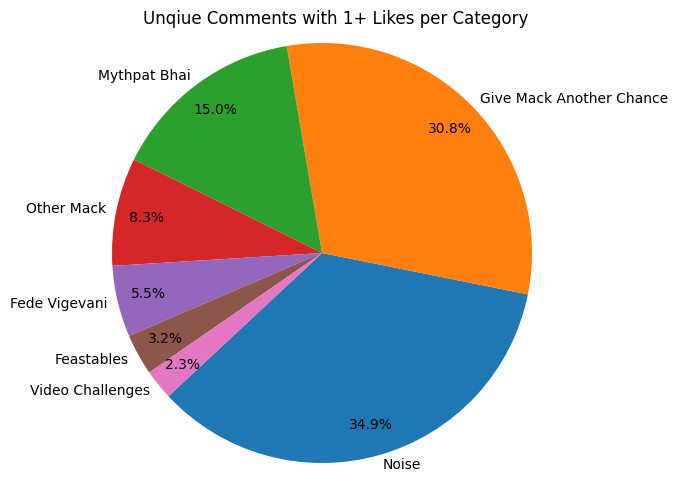

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
comment_counts.plot.pie(
    startangle=-136.98,
    labeldistance=1.05,
    autopct="%.1f%%",
    pctdistance=0.85,
    colors=colors
)
ax.set_ylabel('')
fig.suptitle("Unqiue Comments with 1+ Likes per Category", x=0.53, y=0.90)
ax.axis('equal')
plt.show()

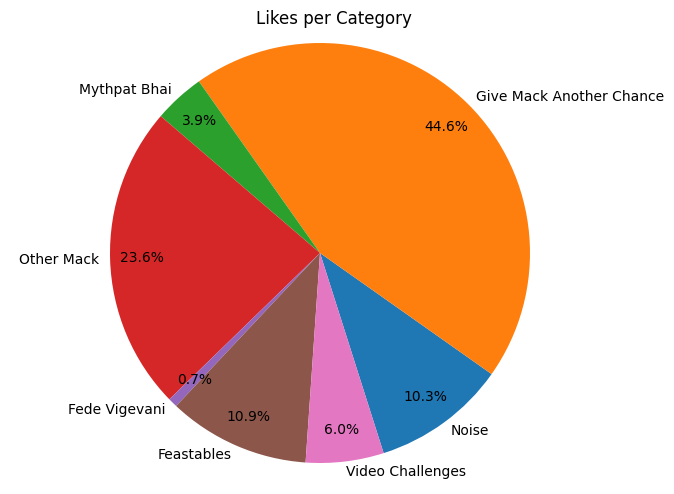

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
likes_by_topic.plot.pie(
    startangle=-72.36,
    labeldistance=1.05,
    autopct="%.1f%%",
    pctdistance=0.85,
    colors=colors
)
ax.set_ylabel('')
fig.suptitle("Likes per Category", x=0.53, y=0.90)
ax.axis('equal')
plt.show()